<h1><center>Named Entity Recognition Model using  Clinical BERT </center></h1>
<h4><center>Final Project W266</center></h4>


<h3><center>SUMMARY</center></h3>

In this notebook, we will look at implementing various BERT models to understand the significance of domain specific contexts with respect to fine tuning NER task.

- The various BERT models used in the notebook are listed below.

__BERT:__ 
>"BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding", by Devlin/Chang/Lee/Toutanova, Google AI Language)

__BioBERT:__ 
>A pre-trained biomedical language representation model for biomedical text mining by Jinhyuk Lee, Wonjin Yoon, Sungdong Kim, Donghyeon Kim, Sunkyu Kim, Chan Ho So, Jaewoo Kang

__SciBERT:__
>A Pretrained Language Model for Scientific Text by Iz Beltagy, Kyle Lo, Arman Cohan

__ClinicalBert:__
>Modeling Clinical Notes and Predicting Hospital Readmission by Kexin Huang, Jaan Altosaar, Rajesh Ranganath

>Publicly Available Clinical BERT Embeddings by Emily Alsentzer, John R. Murphy, Willie Boag, Wei-Hung Weng, Di Jin, Tristan Naumann, Matthew B. A. McDermott


Models used and their corresponding Corpora used:


__Base Bert Cased -__  

>Wikipedia + BookCorpus

__BioBert Cased with PubMed and PMC - __

>English Wikipedia, General BooksCorpus, General PubMed Abstracts, PMC Full-text articles

__SciBert Cased -__

>1.14M papers from Semantic Scholar (Ammar et al., 2018)

__biobert_pretrain_output_all_notes_150000__

>MIMIC text from all note types on BioBert


__biobert_pretrain_output_disch_100000__

>MIMIC text from all discharge summaries on BioBert


We look at the effect of also fine-tuning BERT layers which are pre-trained with clinical context. 


### 1. Data



In [1]:
!tail -20 'ner_dataset.csv'

",",",",O
M.D,NNP,O
JA25,NNP,O
Attending:,NNP,O
SYDNEY,NNP,O
DUESTERHAUS,NNP,O
",",",",O
M.D,NNP,O
MG85,NNP,O
EQ681/3978,NNP,O
Batch:,NNP,O
37609,CD,O
Index,NNP,O
No,NNP,O
FHOW8875S8,NNP,O
D:,NNP,O
6/10,CD,O
T:,NNP,O
1/22,CD,O
[report_end],NN,O


### Scintific  BERT


We start with some imports, adding the data and bert path, and then completing all imports.

In [2]:
!pip install seqeval[gpu]

In [3]:
import warnings 
warnings.filterwarnings('ignore')
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
#import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange


from datetime import datetime
import os
import sys
import zipfile



In [4]:

# Define mddaximal length of input 'sentences' (post tokenization).
max_word = 40
max_length = 64

In [5]:

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

Using TensorFlow backend.


In [6]:
MAX_LEN = 128
bs = 32

In [7]:
print(os.listdir("/root"))
print(os.listdir("/root/scibert_scivocab_cased"))


['All Models.ipynb', 'scibert_scivocab_cased', 'cuda-repo-ubuntu1604-10-1-local-10.1.168-418.67_1.0-1_amd64.deb', 'ner_tags', 'vocab.txt', 'biobert_pretrain_output_disch_100000', 'biobert_working-pytorch-gpu_v1.ipynb', '.gnupg', 'clibert.bin', 'sentence_boundaries.ipynb', 'all_bert_models-50.ipynb', 'validation_sentences.csv', 'Baseline_model.ipynb', 'biobert.bin', 'scibert-pytorch-gpu.ipynb', 'biobert_pretrain_output_all_notes_150000', 'clinicalbert.bin', 'attention_decoder.py', 'bert_config.json', 'cuda-repo-ubuntu1604-10-1-local-10.1.105-418.39_1.0-1_amd64.deb', 'clinicalbert-pytorch-gpu_notes.ipynb', 'validation_ner.csv', 'pytorch_model.bin', 'sentence_model.h5', '.profile', '.config', 'ner_dataset.csv', 'clinicalbert_working-pytorch-gpu_v1.ipynb', 'data', 'convert_to_pytorch_wt.ipynb', '.keras', '.nv', '.bash_history', 'eos.pyc', 'connengine.ipynb', 'answers', 'parser-bert.ipynb', 'bert_working-pytorch-gpu_v1.ipynb', '.pytorch_pretrained_bert', 'best_model.hdf5', 'config.json', '.

In [8]:
VOCAB = '/root/scibert_scivocab_cased/vocab.txt'
MODEL = '/root/scibert_scivocab_cased'

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [10]:
torch.cuda.get_device_name(0) 

'Tesla P100-PCIE-16GB'

## III. Data Preprocessing <a id="preprocess" />

### III.1 BERT Tokenizer<a id="tokenizer" />

We first start by defining and exploring the BERT tokenizer:

In [11]:
tokenizer = BertTokenizer.from_pretrained('/root/scibert_scivocab_cased', do_lower_case=False)

In [12]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer1 = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [13]:
# Tokenized input
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
print (tokenized_text)


['[CLS]', 'Wh', '##o', 'was', 'Jim', 'Hen', '##son', '?', '[SEP]', 'Jim', 'Hen', '##son', 'was', 'a', 'pup', '##pet', '##ee', '##r', '[SEP]']


In [14]:
tokenizer.tokenize('I\'ll learn to swim in 12342 years.')

['I',
 "'",
 'll',
 'learn',
 'to',
 'sw',
 '##im',
 'in',
 '123',
 '##42',
 'years',
 '.']

Note how the "I'll" phrase and the number '12342' got split. This already highlights an area one needs to address: splitting of tokens will need to be accounted for in the labeling.

In [15]:
tokenizer.convert_tokens_to_ids(['I',
 "'",
 'll',
 'learn',
 'to',
 'sw',
 '##im',
 'in',
 '123',
 '##42',
 'years',
 '.'])

[179, 2517, 8939, 4298, 146, 2170, 162, 124, 14796, 5593, 1314, 211]

In [16]:
tokenizer.convert_ids_to_tokens([20958])

['locom']

Good. Now we are ready to use it for our text.

### III.2. Extraction<a id="extract"/>


We have seen above how the data set looks. We can now turn to the pre-processing and creating the input for BERT. Specifically, we need to:

1) Tokenize the sentences. Note again that one word can be split into multiple tokens, and we need to insert custom labels when that happens to make sure we don't mess up the alignment. We choose a new 'nerX' label here.

2) Create BERT tokens and add [CLS], [PAD], etc.

3) Convert these tokens into ids, also via the tokenizer. These qill create the sentence_ids.

4) Create the mask ids. Mask out all of the padding tokens.

5) Create the sequence ids. In our case, they are all '0' as we do not compare or even have multiple sentences in one example.

To do this, we first define a helper function:

*This piece has been reused from the course notebook and modified

In [17]:
def addWord(word, pos, ner):
    """
    Convert a word into a word token and add supplied NER and POS labels. Note that the word can be  
    tokenized to two or more tokens. Correspondingly, we add - for now - custom 'X' tokens to the labels in order to 
    maintain the 1:1 mappings between word tokens and labels.
    
    arguments: word, pos label, ner label
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['posToken'] = [pos] + ['posX'] * (tokenLength - 1)
    addDict['nerToken'] = [ner] + ['nerX'] * (tokenLength - 1)
    addDict['tokenLength'] = tokenLength
    
    
    return addDict


Let's see what it does:

In [18]:
addWord('protest', 'VB', 'O')

{'wordToken': ['prote', '##st'],
 'posToken': ['VB', 'posX'],
 'nerToken': ['O', 'nerX'],
 'tokenLength': 2}

In [19]:
addWord('Iraq', 'NNP', 'B-geo')

{'wordToken': ['Ir', '##a', '##q'],
 'posToken': ['NNP', 'posX', 'posX'],
 'nerToken': ['B-geo', 'nerX', 'nerX'],
 'tokenLength': 3}

In [20]:
addWord('10000', 'CD', 'O')

{'wordToken': ['10000'],
 'posToken': ['CD'],
 'nerToken': ['O'],
 'tokenLength': 1}

We are now ready to convert the text file into appropriate arrays:

In [21]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

with io.open('ner_dataset.csv', 'r', encoding='utf-8', errors='ignore') as train:
    text = train.readlines()


# lists for sentences, tokens, labels, etc.  
sentenceList = []
word_count = 0
sentenceTokenList = []
posTokenList = []
nerTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

sentence = ''

# always start with [CLS] tokens
sentenceTokens = ['[CLS]']
posTokens = ['[posCLS]']
nerTokens = ['[nerCLS]']

for line in text:
    
    cleanLine = re.sub(r'(?!(([^"]*"){2})*[^"]*$),', '', line)  # deal with '"10,000"' and convert them to '10000' 

    word, pos, ner = cleanLine.split(',')
    
    ner = ner[:-1]   # remove DOS token
    
    # if new sentence starts
    if (word_count >= max_word -1):            
            
        sentenceLength = min(max_length -1, len(sentenceTokens))
        sentLengthList.append(sentenceLength)
        
                    
        # Create space for at least a final '[SEP]' token
        if sentenceLength >= max_length - 1: 
            sentenceTokens = sentenceTokens[:max_length - 2]
            posTokens = posTokens[:max_length - 2]
            nerTokens = nerTokens[:max_length - 2]

        # add a ['SEP'] token and padding
        
        sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
        
        posTokens += ['[posSEP]'] + ['[posPAD]'] * (max_length - 1 - len(posTokens) )
        nerTokens += ['[nerSEP]'] + ['[nerPAD]'] * (max_length - 1 - len(nerTokens) )
            
        sentenceList.append(sentence)

        sentenceTokenList.append(sentenceTokens)

        bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
        bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length -1 - sentenceLength ))
        bertSequenceIDs.append([0] * (max_length))
                             
        posTokenList.append(posTokens)
        nerTokenList.append(nerTokens)
        
        sentence = ''
        sentenceTokens = ['[CLS]']
        posTokens = ['[posCLS]']
        nerTokens = ['[nerCLS]']
        
        sentence += ' ' + word
        word_count = 0
    
    word_count += 1
    addDict = addWord(word, pos, ner)

    sentenceTokens += addDict['wordToken']
    posTokens += addDict['posToken']
    nerTokens += addDict['nerToken']

# The first two list elements need to be removed. 1st line in file is a-typical, and 2nd line does not end a sentence   
sentLengthList = sentLengthList[2:]
sentenceTokenList = sentenceTokenList[2:]
bertSentenceIDs = bertSentenceIDs[2:]
bertMasks = bertMasks[2:]
bertSequenceIDs = bertSequenceIDs[2:]
posTokenList = posTokenList[2:]
nerTokenList = nerTokenList[2:]

What did this do?

In [22]:
print(sentLengthList[4])

45


In [23]:
print(bertSentenceIDs[4])

[101, 1198, 202, 2426, 7902, 907, 538, 6096, 1540, 1540, 136, 619, 272, 537, 12551, 326, 10456, 13035, 2403, 10319, 186, 3466, 125, 10456, 23642, 606, 111, 3214, 125, 111, 11070, 1540, 1540, 768, 345, 1327, 2877, 253, 5555, 1791, 146, 20234, 550, 282, 3657, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
print(sentenceTokenList[4])

['[CLS]', 'reported', 'that', 'her', 'foot', 'had', 'been', 'blue', '"', '"', 'and', 'there', 'were', 'no', 'Doppler', '##able', 'pulses', 'Color', 'later', 'returned', 'The', 'absence', 'of', 'pulses', 'persisted', 'over', 'the', 'course', 'of', 'the', 'night', '"', '"', 'after', 'which', 'point', 'she', 'was', 'referred', 'back', 'to', 'Lar', '##gr', '##ine', 'Medical', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [25]:
print(nerTokenList[4])

['[nerCLS]', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'nerX', 'nerX', 'O', '[nerSEP]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]', '[nerPAD]']


In [26]:
print(bertMasks[4])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This looks right. Everything past the '[SEP]' token, i.e., the '[nerSEP]' label, is masked out. Also the sequence_ids are correct: there is only one sentence, so all ids should have the same value of zero.

In [27]:
print(bertSequenceIDs[4])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Looks reasonable. 


### III.3. Initial Data Analysis<a id="analysis" />

It is important to understand the dataset prior to doing any modeling or training. First, what are the length of the original sentences.

(array([3.000e+00, 0.000e+00, 1.900e+01, 0.000e+00, 0.000e+00, 6.300e+01,
        0.000e+00, 0.000e+00, 8.900e+01, 0.000e+00, 1.440e+02, 0.000e+00,
        0.000e+00, 1.800e+02, 0.000e+00, 0.000e+00, 2.280e+02, 0.000e+00,
        2.640e+02, 0.000e+00, 0.000e+00, 2.950e+02, 0.000e+00, 0.000e+00,
        2.890e+02, 0.000e+00, 2.720e+02, 0.000e+00, 0.000e+00, 3.030e+02,
        0.000e+00, 0.000e+00, 2.860e+02, 0.000e+00, 0.000e+00, 2.620e+02,
        0.000e+00, 2.780e+02, 0.000e+00, 0.000e+00, 2.410e+02, 0.000e+00,
        0.000e+00, 2.010e+02, 0.000e+00, 2.110e+02, 0.000e+00, 0.000e+00,
        1.830e+02, 0.000e+00, 0.000e+00, 1.640e+02, 0.000e+00, 1.700e+02,
        0.000e+00, 0.000e+00, 1.640e+02, 0.000e+00, 0.000e+00, 1.660e+02,
        0.000e+00, 3.013e+03]),
 array([40.        , 40.37096774, 40.74193548, 41.11290323, 41.48387097,
        41.85483871, 42.22580645, 42.59677419, 42.96774194, 43.33870968,
        43.70967742, 44.08064516, 44.4516129 , 44.82258065, 45.19354839,
        4

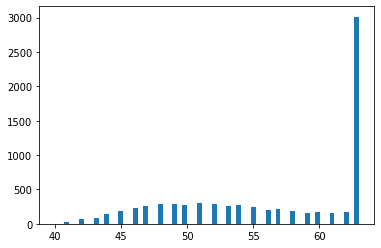

In [28]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

An average sentence length of ~25 (incl. extra tokens!) is roughly expected. It turns out that on these types of corpora an average sentence length of ~20 tends to be seen. The big spike on the right obviously corresponds to all sentences that we had to truncate. 

Next, we analyze the distribution of ner labels. First, we assign numbers to the labels and look at the overall distribution:

In [29]:
numSentences = len(bertSentenceIDs)

nerClasses = pd.DataFrame(np.array(nerTokenList).reshape(-1))
nerClasses.columns = ['tag']
nerClasses.tag = pd.Categorical(nerClasses.tag)
nerClasses['cat'] = nerClasses.tag.cat.codes
nerClasses['sym'] = nerClasses.tag.cat.codes
nerLabels = np.array(nerClasses.cat).reshape(numSentences, -1) 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc947977320>]],
      dtype=object)

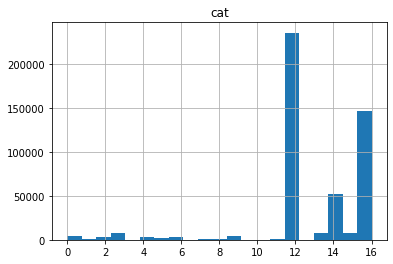

In [30]:
nerClasses[['cat']].hist(bins=21)

Looks like a lot of tables with value 16+... Let's see which labels these label numbers corresponds to:

In [31]:
nerDistribution = (nerClasses.groupby(['tag', 'cat']).agg({'sym':'count'}).reset_index()
                   .rename(columns={'sym':'occurences'}))

numNerClasses = nerDistribution.tag.nunique()

nerDistribution

,tag,cat,occurences
0,B-do,0,3913
1,B-du,1,520
2,B-f,2,3537
3,B-m,3,8089
4,B-mo,4,2935
5,B-r,5,1555
6,I-do,6,3502
7,I-du,7,1103
8,I-f,8,1196
9,I-m,9,3863


Interesting. 12 corresponds to 'O', and all 'extension' labels (i.e., those that were not part of the original data) occur at 13+. 

'O' is the most common token - by far.

### III.4. Baseline: Always picking 'Other'<a id="baseline" />

Let's see what a baseline would give for the actual text tokens, if I ALWAYS chose the most common token 'O':

In [32]:
O_occurences = nerDistribution.loc[nerDistribution.tag == 'O','occurences']
All_occurences = nerDistribution[nerDistribution.cat < 13]['occurences'].sum()

O_occurences/All_occurences

12    0.882147
Name: occurences, dtype: float64

So **88.5%** is the baseline

### III.5. Train/Test Split and Final Data Preparation<a id="split" />

In the last step we need to prepare both labels and input for the model, including the train/test split.

In [33]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])



In [34]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(bertSentenceIDs, nerLabels, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(bertMasks, bertSentenceIDs,
                                             random_state=2018, test_size=0.1)

In [35]:
print(tr_masks[6])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:
print(tr_inputs[6])

[101, 231, 22927, 138, 294, 16027, 30105, 864, 186, 1607, 441, 105, 3290, 125, 4330, 4330, 1595, 803, 1540, 1540, 368, 253, 201, 2311, 3990, 2858, 125, 5665, 30155, 4473, 345, 253, 1007, 3857, 13572, 4440, 193, 824, 193, 198, 4473, 14593, 2529, 3427, 125, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [37]:
tr_tags[6]

array([13, 12, 12, 16, 12, 12, 16, 16, 12, 12, 12, 12, 12, 12,  5,  5, 12,
       12, 12, 16, 12, 12, 12, 12, 12, 12, 12,  3, 16,  9, 12, 12,  0,  6,
        4,  2, 12, 12, 12, 12,  3,  0,  6, 12, 12, 15, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14], dtype=int8)

In [38]:
print(sentenceTokenList[6])

['[CLS]', 'on', 'the', '2', 'of', 'September', 'PAS', '##T', 'SU', '##RG', '##ICAL', 'HI', '##ST', '##ORY', ':', 'Not', '##able', 'for', 'the', 'above', '"', '"', 'as', 'well', 'as', 'deb', '##rid', '##ements', 'of', 'her', 'to', '##e', 'amp', '##utation', 'wound', 'site', 'AD', '##MI', '##SS', '##ION', 'MED', '##ICATIONS', ':', 'Col', '##ace', '100', 'mg', 'b', '.', 'i', '.', 'd', '"', '"', 'insulin', 'Le', '##nt', '##e', '12', 'units', 'subc', '##u', '[SEP]', '[PAD]']


In [39]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags, dtype=torch.long, device=device)
val_tags = torch.tensor(val_tags, dtype=torch.long, device=device)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [40]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [41]:
#config = BertConfig.from_json_file('/root/biobert_v1.0_pubmed_pmc/bert_config.json')
model = BertForTokenClassification.from_pretrained('/root/scibert_scivocab_cased', num_labels=nerDistribution['tag'].count())
#model = BertForTokenClassification.from_pretrained("scibert-basevocab-cased", num_labels=len(tag2idx))

In [42]:
print(model)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementw

In [43]:
for name, param in model.named_parameters():                
    print (name)
    #if name.startswith('embeddings'):
    #    param.requires_grad = False

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [44]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

In [45]:
model.cuda();

In [46]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report, accuracy_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [47]:
epochs = 50
max_grad_norm = 1.0

train_loss = []
evaluation_loss = []
f1score = []
for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    train_loss.append(tr_loss/nb_tr_steps)
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    evaluation_loss.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == p_i).idxmax()][0] for p in predictions for p_i in p])
    valid_tags = np.array([nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][0] for l in true_labels for l_i in l for l_ii in l_i])
    valid_ids = [nerDistribution.loc[(nerDistribution['cat'] == l_ii).idxmax()][1] for l in true_labels for l_i in l for l_ii in l_i]
    mask = (np.array(valid_ids) < 13)
    #print(mask)
    pred = np.ma.compressed(np.ma.MaskedArray(pred_tags, mask=~mask))
    valid = np.ma.compressed(np.ma.MaskedArray(valid_tags, mask=~mask))
    #print(pred.tolist())
    print("F1-Score: {}".format(f1_score(pred.tolist(), valid.tolist())))
    f1score.append(f1_score(pred.tolist(), valid.tolist()))
    print("Recall: {}".format(recall_score(pred.tolist(), valid.tolist())))
    

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train loss: 0.5655212122682146
Validation loss: 0.23993235950668654
Validation Accuracy: 0.8316759940905448


Epoch:   2%|▏         | 1/50 [02:39<2:10:18, 159.56s/it]

F1-Score: 0.5130674002751032
Recall: 0.4814974182444062
Train loss: 0.20543603203590446
Validation loss: 0.14329310289273658
Validation Accuracy: 0.8581746419270834


Epoch:   4%|▍         | 2/50 [05:19<2:07:42, 159.63s/it]

F1-Score: 0.7182858534209886
Recall: 0.7129047849202513
Train loss: 0.12526998836635414
Validation loss: 0.1104931343967716
Validation Accuracy: 0.866680438701923


Epoch:   6%|▌         | 3/50 [07:59<2:05:12, 159.85s/it]

F1-Score: 0.7561499880582756
Recall: 0.7366216845044207
Train loss: 0.08629885345909268
Validation loss: 0.10039241674045722
Validation Accuracy: 0.8692047901642628


Epoch:   8%|▊         | 4/50 [10:38<2:02:17, 159.52s/it]

F1-Score: 0.7979502196193266
Recall: 0.7936893203883495
Train loss: 0.06530304883399281
Validation loss: 0.09538183050851028
Validation Accuracy: 0.8692032251602564


Epoch:  10%|█         | 5/50 [13:18<1:59:51, 159.81s/it]

F1-Score: 0.7700210133084286
Recall: 0.734521158129176
Train loss: 0.050053893795934334
Validation loss: 0.09431339877968033
Validation Accuracy: 0.8712565104166666


Epoch:  12%|█▏        | 6/50 [15:59<1:57:17, 159.94s/it]

F1-Score: 0.8014117647058824
Recall: 0.7698915009041591
Train loss: 0.04023201101110869
Validation loss: 0.09832621598616242
Validation Accuracy: 0.8703597631209936


Epoch:  14%|█▍        | 7/50 [18:38<1:54:30, 159.77s/it]

F1-Score: 0.7891469303288111
Recall: 0.7425356988316746
Train loss: 0.032146436563953405
Validation loss: 0.09548972143481176
Validation Accuracy: 0.8717197516025642


Epoch:  16%|█▌        | 8/50 [21:17<1:51:38, 159.48s/it]

F1-Score: 0.8098391674550617
Recall: 0.7817351598173516
Train loss: 0.026441645155267975
Validation loss: 0.0987687036395073
Validation Accuracy: 0.8714646559495192


Epoch:  18%|█▊        | 9/50 [23:56<1:48:53, 159.34s/it]

F1-Score: 0.808659217877095
Recall: 0.7692648361381754
Train loss: 0.021571599264845465
Validation loss: 0.10014227622499068
Validation Accuracy: 0.872837164463141


Epoch:  20%|██        | 10/50 [26:35<1:46:08, 159.22s/it]

F1-Score: 0.8235574630424416
Recall: 0.8010204081632653
Train loss: 0.01787774577092432
Validation loss: 0.10145549879719813
Validation Accuracy: 0.8728074293870192


Epoch:  22%|██▏       | 11/50 [29:14<1:43:30, 159.24s/it]

F1-Score: 0.8219821512447159
Recall: 0.7882882882882883
Train loss: 0.015466280219749816
Validation loss: 0.1111982266108195
Validation Accuracy: 0.873081305088141


Epoch:  24%|██▍       | 12/50 [31:54<1:41:00, 159.47s/it]

F1-Score: 0.8165399239543726
Recall: 0.791705069124424
Train loss: 0.013218843336195036
Validation loss: 0.11836678721010685
Validation Accuracy: 0.8730327899639424


Epoch:  26%|██▌       | 13/50 [34:34<1:38:20, 159.49s/it]

F1-Score: 0.8229141906346567
Recall: 0.7980636237897649
Train loss: 0.011071518604241982
Validation loss: 0.11244797970478733
Validation Accuracy: 0.8729216746794872


Epoch:  28%|██▊       | 14/50 [37:13<1:35:41, 159.48s/it]

F1-Score: 0.8211420481359131
Recall: 0.7909090909090909
Train loss: 0.009325447396300203
Validation loss: 0.12391890569900472
Validation Accuracy: 0.8736431415264424


Epoch:  30%|███       | 15/50 [39:53<1:33:02, 159.51s/it]

F1-Score: 0.8268182895048566
Recall: 0.7993586807146129
Train loss: 0.008857015238951238
Validation loss: 0.1200571369069318
Validation Accuracy: 0.8733692658253206


Epoch:  32%|███▏      | 16/50 [42:33<1:30:27, 159.63s/it]

F1-Score: 0.8202434948675101
Recall: 0.798698279869828
Train loss: 0.007554800841092216
Validation loss: 0.12121105783929427
Validation Accuracy: 0.8735382862580128


Epoch:  34%|███▍      | 17/50 [45:12<1:27:45, 159.55s/it]

F1-Score: 0.821547223540579
Recall: 0.7954963235294118
Train loss: 0.006404846498380764
Validation loss: 0.12443368773286541
Validation Accuracy: 0.8736118414463142


Epoch:  36%|███▌      | 18/50 [47:51<1:25:00, 159.39s/it]

F1-Score: 0.8296261239943209
Recall: 0.8011882998171846
Train loss: 0.0063792352169593225
Validation loss: 0.12951372967412075
Validation Accuracy: 0.8728700295472757


Epoch:  38%|███▊      | 19/50 [50:30<1:22:21, 159.42s/it]

F1-Score: 0.8202830188679244
Recall: 0.7897366030881017
Train loss: 0.005264005448583125
Validation loss: 0.13047782999152938
Validation Accuracy: 0.8734162159455128


Epoch:  40%|████      | 20/50 [53:09<1:19:38, 159.30s/it]

F1-Score: 0.8272102393932211
Recall: 0.8000917010545622
Train loss: 0.005070425019245286
Validation loss: 0.13245934527367353
Validation Accuracy: 0.873996832431891


Epoch:  42%|████▏     | 21/50 [55:49<1:17:00, 159.31s/it]

F1-Score: 0.8325748502994013
Recall: 0.8132896583996256
Train loss: 0.004824203330365791
Validation loss: 0.13907781460632881
Validation Accuracy: 0.8744976337139424


Epoch:  44%|████▍     | 22/50 [58:28<1:14:23, 159.41s/it]

F1-Score: 0.8401177047572339
Recall: 0.8397058823529412
Train loss: 0.004796839168270988
Validation loss: 0.13734647817909718
Validation Accuracy: 0.8743739983974358


Epoch:  46%|████▌     | 23/50 [1:01:08<1:11:47, 159.54s/it]

F1-Score: 0.8360931125509959
Recall: 0.8182245185533115
Train loss: 0.0042408284785278956
Validation loss: 0.1333031253889203
Validation Accuracy: 0.8736008864182692


Epoch:  48%|████▊     | 24/50 [1:03:49<1:09:13, 159.77s/it]

F1-Score: 0.8298774740810556
Recall: 0.7982774252039891
Train loss: 0.0037728696127733333
Validation loss: 0.12975909607484937
Validation Accuracy: 0.8740390875400642


Epoch:  50%|█████     | 25/50 [1:06:29<1:06:37, 159.89s/it]

F1-Score: 0.8346793349168646
Recall: 0.8089318600368324
Train loss: 0.0037372021416425087
Validation loss: 0.13460492870459953
Validation Accuracy: 0.8742221930088142


Epoch:  52%|█████▏    | 26/50 [1:09:09<1:03:58, 159.95s/it]

F1-Score: 0.8332534738859607
Recall: 0.8141385767790262
Train loss: 0.003375693290992044
Validation loss: 0.13785639218986034
Validation Accuracy: 0.874538323818109


Epoch:  54%|█████▍    | 27/50 [1:11:48<1:01:15, 159.82s/it]

F1-Score: 0.8341830541393543
Recall: 0.8255646323882748
Train loss: 0.003428829784485207
Validation loss: 0.13493835522482792
Validation Accuracy: 0.8739577073317308


Epoch:  56%|█████▌    | 28/50 [1:14:29<58:38, 159.94s/it]  

F1-Score: 0.8333333333333334
Recall: 0.8072677092916284
Train loss: 0.003087374995935982
Validation loss: 0.14262666118641695
Validation Accuracy: 0.8742722731370192


Epoch:  58%|█████▊    | 29/50 [1:17:09<56:02, 160.12s/it]

F1-Score: 0.8342501793829228
Recall: 0.8138124125058329
Train loss: 0.0036431996504775075
Validation loss: 0.13455250083158413
Validation Accuracy: 0.8742519280849358


Epoch:  60%|██████    | 30/50 [1:19:49<53:23, 160.19s/it]

F1-Score: 0.840705825477399
Recall: 0.8284897570271558
Train loss: 0.0031400189242713037
Validation loss: 0.13742686187227568
Validation Accuracy: 0.8748403695913461


Epoch:  62%|██████▏   | 31/50 [1:22:29<50:42, 160.11s/it]

F1-Score: 0.8369171297414835
Recall: 0.8243693479295574
Train loss: 0.003474522480642935
Validation loss: 0.14782896544784307
Validation Accuracy: 0.8749029697516025


Epoch:  64%|██████▍   | 32/50 [1:25:09<47:59, 159.98s/it]

F1-Score: 0.8465071307710902
Recall: 0.8342067651262506
Train loss: 0.0028134420399898354
Validation loss: 0.13605719742675623
Validation Accuracy: 0.8734975961538461


Epoch:  66%|██████▌   | 33/50 [1:27:48<45:13, 159.64s/it]

F1-Score: 0.8193227563343594
Recall: 0.7917620137299771
Train loss: 0.0026610868422825428
Validation loss: 0.15010499395430088
Validation Accuracy: 0.8740218724959936


Epoch:  68%|██████▊   | 34/50 [1:30:28<42:36, 159.81s/it]

F1-Score: 0.8357178095707943
Recall: 0.8402777777777778
Train loss: 0.0026300584422772025
Validation loss: 0.1440432995247344
Validation Accuracy: 0.8744866786858975


Epoch:  70%|███████   | 35/50 [1:33:08<39:56, 159.75s/it]

F1-Score: 0.8343294286397324
Recall: 0.8135198135198135
Train loss: 0.0020580888367950434
Validation loss: 0.14315873819092909
Validation Accuracy: 0.874782464443109


Epoch:  72%|███████▏  | 36/50 [1:35:47<37:15, 159.66s/it]

F1-Score: 0.8433212996389893
Recall: 0.8275862068965517
Train loss: 0.0019600191686006694
Validation loss: 0.14680077166606983
Validation Accuracy: 0.8751878004807692


Epoch:  74%|███████▍  | 37/50 [1:38:28<34:38, 159.85s/it]

F1-Score: 0.8460417678484701
Recall: 0.8375
Train loss: 0.002101214622072622
Validation loss: 0.14986615752180418
Validation Accuracy: 0.8750563401442308


Epoch:  76%|███████▌  | 38/50 [1:41:08<31:58, 159.90s/it]

F1-Score: 0.8397683397683398
Recall: 0.8262108262108262
Train loss: 0.002569268027275538
Validation loss: 0.1439256053417921
Validation Accuracy: 0.8751690204326924


Epoch:  78%|███████▊  | 39/50 [1:43:46<29:15, 159.56s/it]

F1-Score: 0.8385542168674699
Recall: 0.8238636363636364
Train loss: 0.0021494247108740376
Validation loss: 0.14514667633920908
Validation Accuracy: 0.8741611578525642


Epoch:  80%|████████  | 40/50 [1:46:26<26:36, 159.65s/it]

F1-Score: 0.835941204362257
Recall: 0.8087155963302752
Train loss: 0.0025166653078261838
Validation loss: 0.14324937916050354
Validation Accuracy: 0.8749139247796475


Epoch:  82%|████████▏ | 41/50 [1:49:06<23:57, 159.69s/it]

F1-Score: 0.8425634824667473
Recall: 0.8307105388650453
Train loss: 0.0017876883928917273
Validation loss: 0.14447294470543662
Validation Accuracy: 0.8750563401442308


Epoch:  84%|████████▍ | 42/50 [1:51:45<21:16, 159.55s/it]

F1-Score: 0.8442307692307693
Recall: 0.827521206409048
Train loss: 0.0017439705881503106
Validation loss: 0.14078185288235545
Validation Accuracy: 0.8758184970953525


Epoch:  86%|████████▌ | 43/50 [1:54:25<18:36, 159.55s/it]

F1-Score: 0.8453105968331303
Recall: 0.8393807450411224
Train loss: 0.0018001485242722423
Validation loss: 0.13839663503070673
Validation Accuracy: 0.8751377203525642


Epoch:  88%|████████▊ | 44/50 [1:57:05<15:57, 159.64s/it]

F1-Score: 0.8455829542734019
Recall: 0.825619448340346
Train loss: 0.0013453776948188455
Validation loss: 0.1559447661663095
Validation Accuracy: 0.8750359950921475


Epoch:  90%|█████████ | 45/50 [1:59:43<13:17, 159.43s/it]

F1-Score: 0.8407984420642648
Recall: 0.8342995169082126
Train loss: 0.0020610507594140673
Validation loss: 0.14793345083793005
Validation Accuracy: 0.874408428485577


Epoch:  92%|█████████▏| 46/50 [2:02:24<10:38, 159.65s/it]

F1-Score: 0.837142169834015
Recall: 0.8211420481359132
Train loss: 0.0019249682029793636
Validation loss: 0.14990317542105913
Validation Accuracy: 0.8746009239783654


Epoch:  94%|█████████▍| 47/50 [2:05:04<07:59, 159.83s/it]

F1-Score: 0.8402479732951836
Recall: 0.8172541743970315
Train loss: 0.0014218272204674731
Validation loss: 0.15663588357468447
Validation Accuracy: 0.8740109174679488


Epoch:  96%|█████████▌| 48/50 [2:07:43<05:19, 159.60s/it]

F1-Score: 0.8287853175561458
Recall: 0.8159771754636234
Train loss: 0.0017303293972950368
Validation loss: 0.15379126432041326
Validation Accuracy: 0.8739295372596154


Epoch:  98%|█████████▊| 49/50 [2:10:23<02:39, 159.73s/it]

F1-Score: 0.8345935727788281
Recall: 0.804922515952598
Train loss: 0.0013616353764639554
Validation loss: 0.16079851426184177
Validation Accuracy: 0.8746588291266025


Epoch: 100%|██████████| 50/50 [2:13:02<00:00, 159.49s/it]

F1-Score: 0.834942084942085
Recall: 0.8214624881291548


In [48]:
!pip install scipy

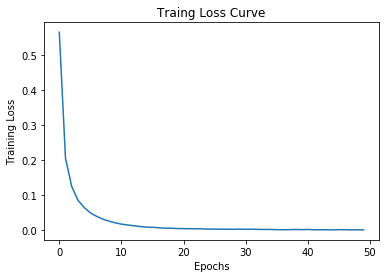

In [49]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Traing Loss Curve")
plt.show()

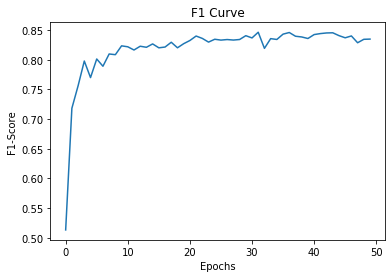

In [50]:
import matplotlib.pyplot as plt

plt.plot(f1score)
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.title("F1 Curve")
plt.show()